In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, ParameterGrid
from sklearn.metrics import (make_scorer, mean_absolute_error, mean_squared_error, 
                             balanced_accuracy_score, classification_report, confusion_matrix) 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_report(y_true, y_pred):
    print("Test MSE: ", mean_squared_error(y_true, y_pred))
    print("Test MAE: ", mean_absolute_error(y_true, y_pred))

In [4]:
RS = 42

In [5]:
df_features = pd.read_csv("features.csv", index_col=0)
labels = pd.read_csv('../data/labels.csv', index_col=0)[['n_cited']]

df = labels.join(df_features)

In [6]:
df = df.iloc[1000:-100]

In [7]:
X, y = df.iloc[:, 1:].values, df.n_cited.values.reshape(-1, 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RS)
y_train[y_train>20] = 20

In [9]:
gbm = lgb.LGBMRegressor(random_state=RS)
gbm.fit(X_train,y_train.ravel())

LGBMRegressor(random_state=42)

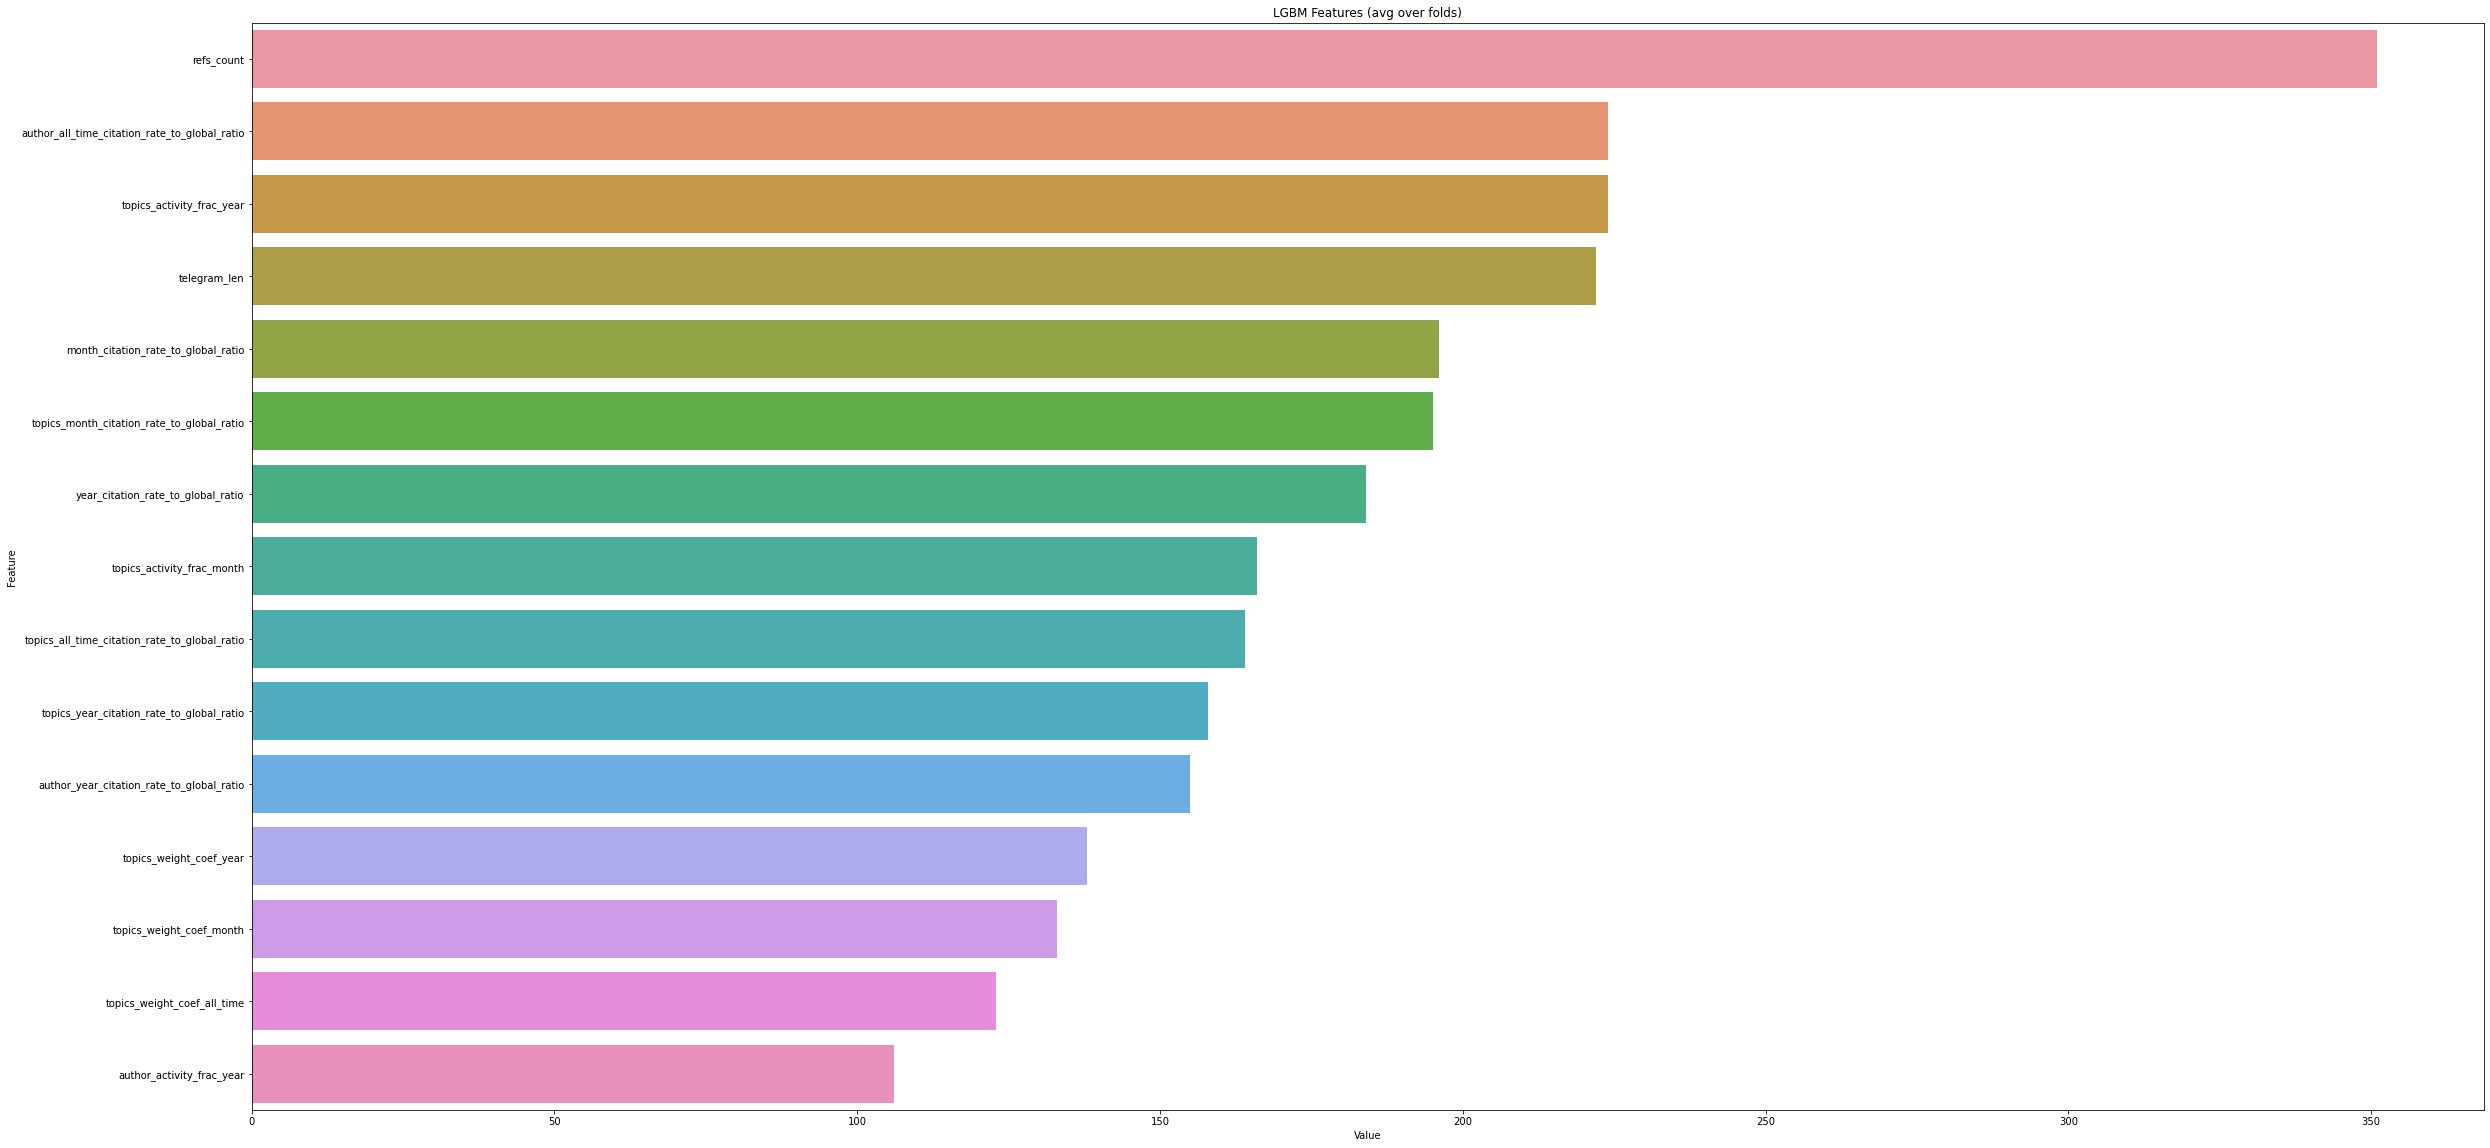

In [10]:
feature_imp = pd.DataFrame({'Value': gbm.feature_importances_, 'Feature': df.iloc[:, 1:].columns})

plt.figure(figsize=(40, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:15])
plt.title('LGBM Features (avg over folds)')
plt.show()

In [11]:
y_pred = gbm.predict(X_test)
y_train_pred = gbm.predict(X_train)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  9.146886401771576
Train MAE:  1.860059383384934
Test MSE:  36.172181695559274
Test MAE:  2.5520372402395304


In [12]:
rf = RandomForestRegressor(random_state=RS, n_estimators=200, max_depth=10)
rf.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

In [13]:
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  7.997290621559677
Train MAE:  1.785674243293086
Test MSE:  36.54968945579199
Test MAE:  2.5722157672575965


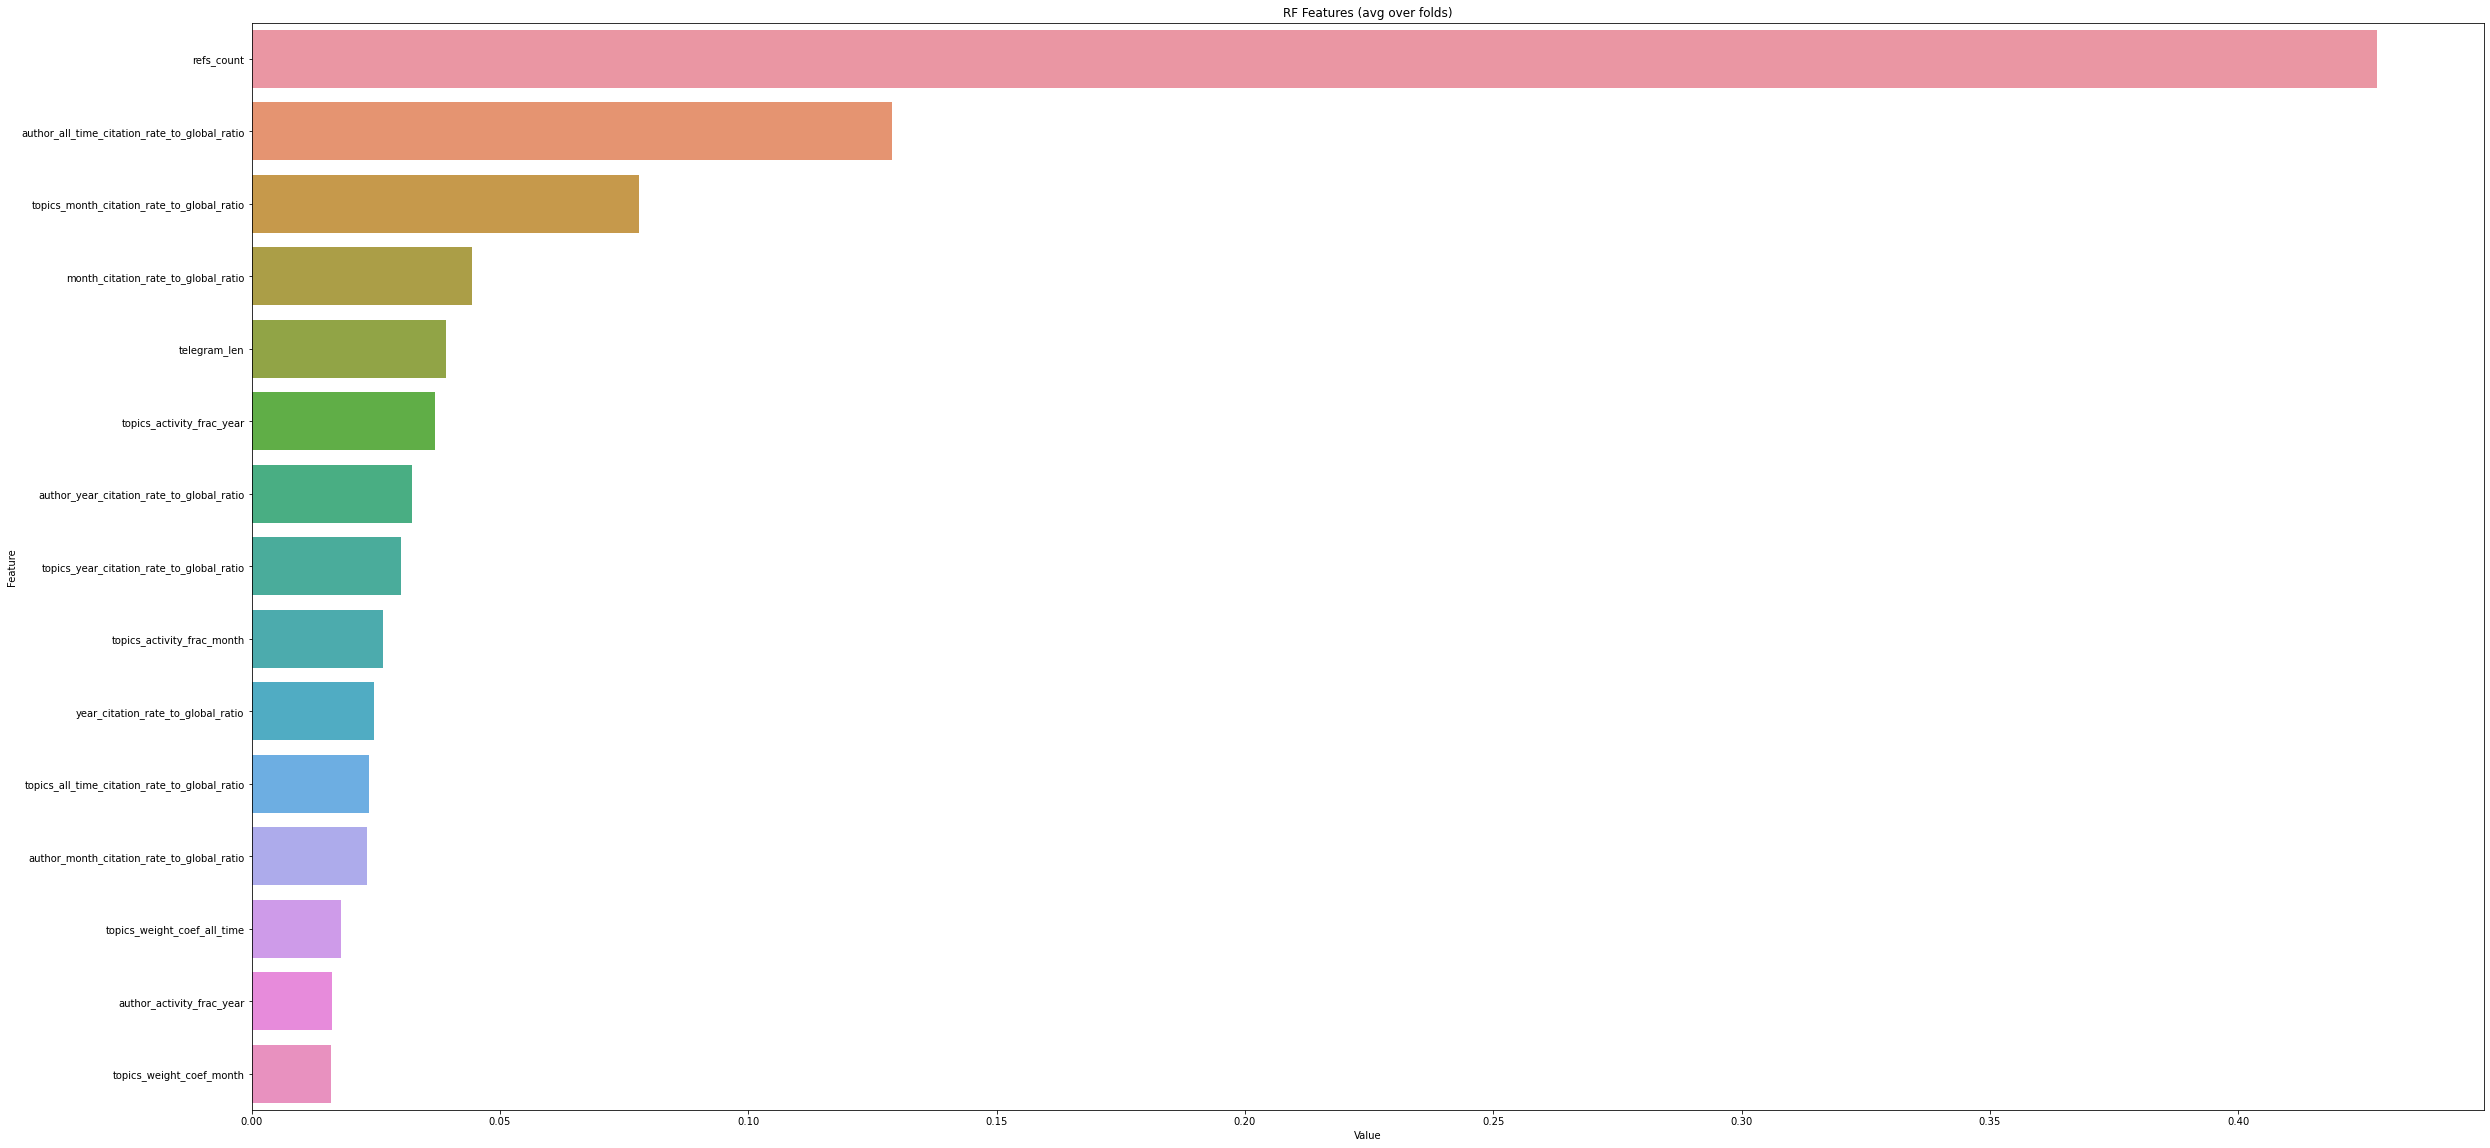

In [14]:
feature_imp = pd.DataFrame({'Value': rf.feature_importances_, 'Feature': df.iloc[:, 1:].columns})

plt.figure(figsize=(40, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:15])
plt.title('RF Features (avg over folds)')
plt.show()

### Will continue with LGBM

In [15]:
NFOLDS = 4
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=RS)

In [16]:
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [17]:
parameters = {
    'n_estimators': [100, 250, 500, 750, 1000],
    'max_depth': [2, 4, 6, -1],
    'reg_alpha': [0.1, 1],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [19]:
model = lgb.LGBMRegressor(random_state=RS)

In [20]:
RSCV = RandomizedSearchCV(model, parameters, scoring=scorer, cv=kf, n_iter=333, verbose=3)

In [21]:
RSCV.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
[CV 1/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-2.928 total time=   0.1s
[CV 2/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-2.952 total time=   0.1s
[CV 3/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-2.920 total time=   0.1s
[CV 4/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=0.1;, score=-2.893 total time=   0.1s
[CV 1/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-2.928 total time=   0.1s
[CV 2/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-2.952 total time=   0.1s
[CV 3/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-2.920 total time=   0.1s
[CV 4/4] END learning_rate=0.001, max_depth=2, n_estimators=100, reg_alpha=1;, score=-2.893 total time=   0.1s
[CV 1/4] END learning_rate=0.001, max_dep

RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=LGBMRegressor(random_state=42), n_iter=333,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [2, 4, 6, -1],
                                        'n_estimators': [100, 250, 500, 750,
                                                         1000],
                                        'reg_alpha': [0.1, 1]},
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                   verbose=3)

In [22]:
best_estimator = RSCV.best_estimator_

In [23]:
y_pred = best_estimator.predict(X_test)  
y_train_pred = best_estimator.predict(X_train)
print("Train MSE: ", mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", mean_absolute_error(y_train, y_train_pred))
get_report(y_test, y_pred)

Train MSE:  7.165503542526004
Train MAE:  1.660324488070414
Test MSE:  35.366044390058335
Test MAE:  2.5156556747938423


In [24]:
RSCV.best_params_

{'reg_alpha': 1, 'n_estimators': 250, 'max_depth': -1, 'learning_rate': 0.1}

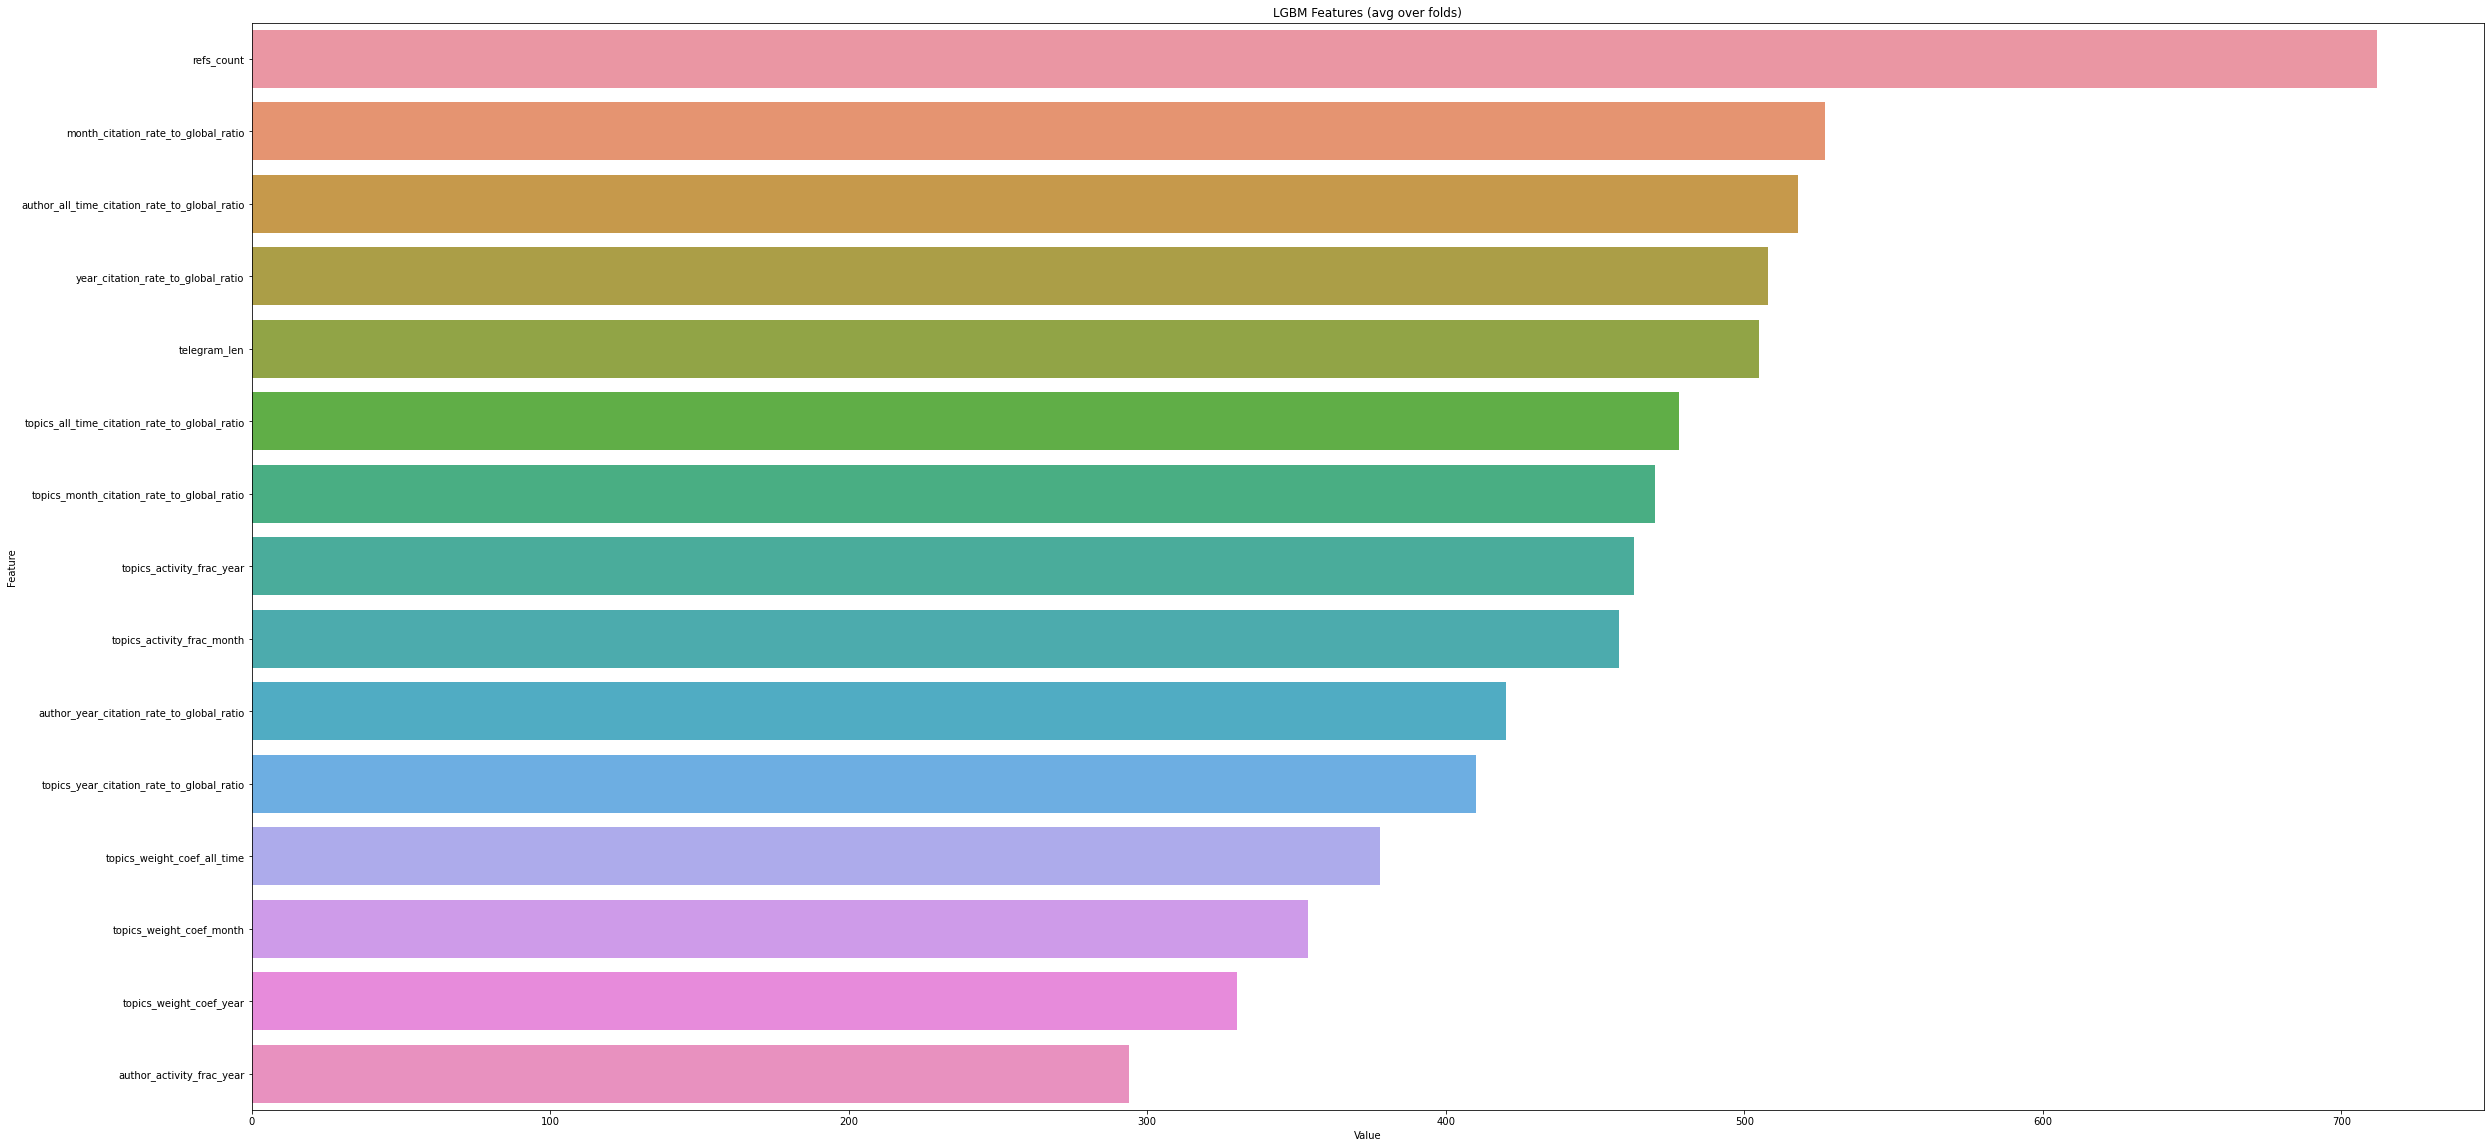

In [25]:
feature_imp = pd.DataFrame({'Value': best_estimator.feature_importances_, 'Feature': df.iloc[:, 1:].columns})

plt.figure(figsize=(40, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:15])
plt.title('LGBM Features (avg over folds)')
plt.show()